In [11]:
import sys 
sys.path.append('/Users/patroklos/Desktop/delphi_')

import torch as ch
from torch import Tensor
from torch.distributions import Uniform
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions.kl import kl_divergence

import seaborn as sns
import matplotlib.pyplot as plt
import IPython 

from delphi.distributions.censored_normal import CensoredNormal
from delphi import oracle
from delphi.utils import constants as consts
from delphi.utils.helpers import setup_store_with_metadata, Parameters
from cox.store import Store
from cox.readers import CollectionReader

In [3]:
args = Parameters({ 
    'samples': 1000, 
    'batch_size': 1, 
    'tol': 1e-1, 
    'lr': 1e-1, 
    'out_dir': '/Users/patroklos/Desktop/exp/censored',
    'exp': 'new_nll_heur_again', 
    'trials': 20,
    'var': 10,
    'table_name': 'logs',
})

Synthetic Data Experiment for 1 Dimensional Censored Gaussian Distributions 

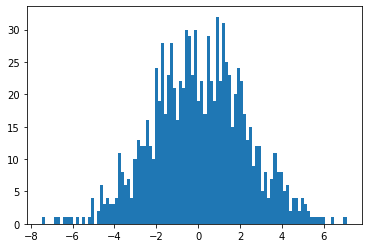

In [34]:
M = MultivariateNormal(Tensor([0.0]), 5.0*ch.ones(1, 1))
samples = M.sample([args.samples])

plt.hist(samples.flatten(), bins=100)
plt.show()

Truncate the Dataset

alpha: 0.494


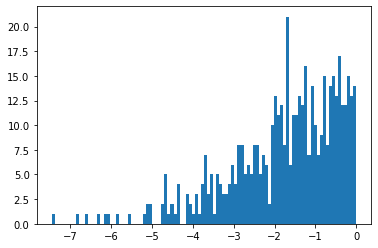

In [35]:
phi = oracle.Right_Distribution(Tensor([0.0]))
# phi = oracle.Identity()
indices = phi(samples).nonzero()[:,0]
S = samples[indices]
alpha = S.size(0) / samples.size(0)
print("alpha: {}".format(alpha))

plt.hist(S.flatten(), bins=100)
plt.show()

In [36]:
emp_loc = S.mean(0)
print("empirical mean: ", emp_loc)
emp_var = S.var(0)[...,None]
emp_scale = ch.sqrt(emp_var)
print("empirical scale: ", emp_scale)

emp = MultivariateNormal(emp_loc, emp_var)

S_norm = (S - emp_loc) / emp_scale
phi_norm = oracle.Right_Distribution(((phi.right - emp_loc) / emp_scale).flatten())

empirical mean:  tensor([-1.7521])
empirical scale:  tensor([[1.3399]])


Run algorithm to Remove Bias from the Dataset

In [37]:
ch.ones(1, 1) / emp_var

tensor([[0.5570]])

In [38]:
train_kwargs = Parameters({'phi': phi_norm, 
                           'alpha': alpha,
                            'epochs': 5, 
                          'batch_size': 10, 
                          'num_samples': 10,
                          'step_lr': 1000,
                          'lr': 1e-1})
censored = CensoredNormal(train_kwargs)
censored.fit(S_norm)
rescale_loc = censored.loc * emp_scale + emp_loc
rescale_var = censored.variance * emp_var
m = MultivariateNormal(rescale_loc, rescale_var)
print("estimated mean: ", rescale_loc)
print("estimated variance: ", rescale_var)

estimated mean:  tensor([[0.2675]])
estimated variance:  tensor([[3.9701]])


In [39]:
print("censored kl divergence: ", kl_divergence(m, M))
print("empirical kl divergence: ", kl_divergence(emp, M))

censored kl divergence:  tensor([0.0195])
empirical kl divergence:  tensor(0.4987)


In [40]:
store = Store(args.out_dir + '/' + args.exp)

schema = { 
    'kl_div_emp': float, 
    'kl_div_censored': float,
    'var': int,
    'alpha': float,
}

store.add_table(args.table_name, schema)

for i in range(args.trials): 
    gt_loc = Uniform(-1, 1).sample([1,])
    for var in range(1, args.var + 1):
        # create new dataset
        gt_scale = var * ch.ones(1, 1)
        gt_dist = MultivariateNormal(gt_loc, gt_scale)
        samples = gt_dist.sample([args.samples])

        # right truncate at 0
        phi = oracle.Right_Distribution(Tensor([0.0]))
        indices = phi(samples).nonzero()[:,0]
        S = samples[indices]
        alpha = S.size(0) / samples.size(0)

        emp_dist = MultivariateNormal(S.mean(0), S.var(0) * ch.ones(1, 1))

        S_norm = (S - emp_dist.loc) / ch.sqrt(emp_dist.covariance_matrix) 
        phi_norm = oracle.Right_Distribution((phi.right - emp_dist.loc) / ch.sqrt(emp_dist.covariance_matrix))


        censored = CensoredNormal(phi_norm, 
                                 alpha, 
                                  {'epochs': 2, 
                                    'bs': 10, 
                                    'num_samples': 10,
                                    'lr': 1e-1})
        censored.fit(S_norm)


        loc_ = (censored.loc * ch.sqrt(emp_dist.covariance_matrix)) + emp_dist.loc
        scale_ = censored.variance * emp_dist.covariance_matrix

        censor_dist = MultivariateNormal(loc_, scale_)

        kl_censor = float(kl_divergence(gt_dist, censor_dist))
        kl_emp = float(kl_divergence(gt_dist, emp_dist))


        store[args.table_name].update_row({ 
            'kl_div_emp': kl_emp, 
            'kl_div_censored': kl_censor,
            'var': var,
            'alpha': alpha,
        })
        store[args.table_name].flush_row()
        
        IPython.display.clear_output()

    
store.close()

Logging in: /Users/patroklos/Desktop/exp/censored/new_nll_heur_again/a08166a7-8cf1-4708-b8e5-578618bb0c45


AssertionError: right size: torch.Size([1, 1]). expecting right size (d,).

In [10]:
reader = CollectionReader(args.out_dir + '/' + args.exp)
logs = reader.df(args.table_name)
reader.close()
logs.head(10)

100%|██████████| 1/1 [00:00<00:00, 96.67it/s]


,kl_div_emp,kl_div_censored,var,alpha,exp_id
0,0.650738,0.005023,1,0.596,6b91620f-7c63-4304-bc8e-becf43d183bc
1,0.885104,0.011463,2,0.587,6b91620f-7c63-4304-bc8e-becf43d183bc
2,0.976660,0.050766,3,0.563,6b91620f-7c63-4304-bc8e-becf43d183bc
3,1.079767,0.000629,4,0.562,6b91620f-7c63-4304-bc8e-becf43d183bc
4,1.018563,0.046430,5,0.545,6b91620f-7c63-4304-bc8e-becf43d183bc
5,0.939171,0.043686,6,0.528,6b91620f-7c63-4304-bc8e-becf43d183bc
6,1.013613,0.051734,7,0.530,6b91620f-7c63-4304-bc8e-becf43d183bc
7,1.093240,0.028941,8,0.537,6b91620f-7c63-4304-bc8e-becf43d183bc
8,0.990693,0.023039,9,0.526,6b91620f-7c63-4304-bc8e-becf43d183bc
9,1.227815,0.008983,10,0.541,6b91620f-7c63-4304-bc8e-becf43d183bc


In [11]:
print("kl emp div: {}".format(logs.kl_div_emp.mean()))
print("kl censor div: {}".format(logs.kl_div_censored.mean()))

kl emp div: 1.4757580121606588
kl censor div: 0.17213519532233476


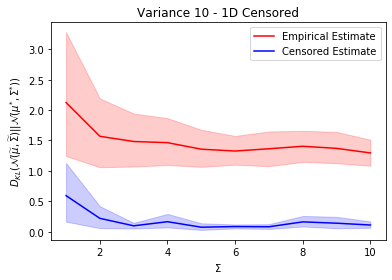

In [12]:
sns.lineplot(data=logs, x='var', y='kl_div_emp', color='red', label='Empirical Estimate')
ax = sns.lineplot(data=logs, x='var', y='kl_div_censored', color='blue', label='Censored Estimate')
ax.set_title('Censored Normal Varying Distribution Variance')
ax.set_xlabel('$\Sigma$')
ax.set_ylabel('$D_{KL}(\mathcal{N}(\widetilde{\mu}, \widetilde{\Sigma}) || \mathcal{N}(\mu^{*}, \Sigma^{*}))$')
ax.set_title('Variance 10 - 1D Censored')
ax.legend()
plt.show()

In [54]:
gt_dist = MultivariateNormal(ch.zeros(1) + .5, ch.ones(1, 1))

In [21]:
gt_loc

tensor(0.1174)

In [62]:
censored.scale

tensor([[0.5863]])

In [13]:
test = ch.randn(5,)

In [14]:
ch.nn.Parameter(test)

Parameter containing:
tensor([-0.6663, -2.3218,  0.3456,  1.4994,  1.4930], requires_grad=True)